# Télécharger le modèle préentraîné

Tomas Chambon a eu la gentillesse de préentraîner ULMfit avec Wikipedia en Français.
- https://github.com/tchambon/deepfrench


Les poids sont disponnibles ici:
- https://drive.google.com/open?id=1_0D3zv5H7iMW1qk7wHNN1yQrHi6arv8g

In [1]:
import pathlib

p = pathlib.Path('.')

ls = lambda x : list(x.iterdir())

In [3]:
ls(p/'large_files')

[PosixPath('large_files/itosref30k.pkl'), PosixPath('large_files/wref30k.pth')]

# Importer Fastai & Fastai.Text

In [5]:
from fastai import *
from fastai.text import *

In [7]:
Tokenizer??

Doc pour le tokenizer : https://docs.fast.ai/text.transform.html#Tokenization

Bon il semble qu'il me faille un dataset

# Trouver un dataset

_Defi Fouille de Textes_ ou *DEFT* pour les intimes https://deft.limsi.fr/


*"2007 : corpus de débats parlementaires, environ 28 000 interventions anonymisées (Hommes et partis politiques) sur des projets de lois relatifs à l'énergie. La valeur de vote (0 = contre, 1 = pour) est indiquée avec chaque document, [apprentissage](https://deft.limsi.fr/corpus/corpus_debats_deft07_apprentissage.tar.gz) [7,4 Mo], [test](https://deft.limsi.fr/corpus/corpus_debats_deft07_test.tar.gz) [4,6 Mo], [reference](https://deft.limsi.fr/corpus/corpus_debats_test_classes.xml) [1,3 Mo]"*

Plutôt intriguant, peut se porter à une tache de classification.

On va entraîner le LM (*language model*) sur train & test comme le conseil _Jeremy Howard_ puis on va séparer le *train set* en 2 80/20 entraîner un modèle de classification et regarder le résultat sur le *test set*.



In [9]:
train_xml = p/'large_files'/'corpus_debats_train.xml'
test_xml  = p/'large_files'/'corpusDebats8-test.xml'

Bon super les données sont dans du XML...

## Explorer le XML

In [16]:
lines = [line.rstrip() for line in open(train_xml, encoding='iso-8859-1')]

print(lines[:10])

['<?xml version="1.0" encoding="iso-8859-1"?>', '<!DOCTYPE CORPUS SYSTEM "deft07.dtd">', '<CORPUS>', '<DESCRIPTION>', "<TITRE>Corpus des débats parlementaires à l'Assemblée Nationale</TITRE>", '<DIFFUSION>', "<CONTACT>Comité d'organisation de DEFT'07</CONTACT>", '<CADRE>Campagne DEFT 2007 - http://deft07.limsi.fr/</CADRE>', '<DISPONIBILITE region="monde" statuts="libre">Utilisable librement à des fins non commerciales</DISPONIBILITE>', '</DIFFUSION>']


In [17]:
print(len(lines))

173030


In [18]:
print(lines[5000:5010])

['</TEXTE>', '</DOCUMENT>', '<DOCUMENT id="4:499">', '<EVALUATION nombre="1">', '<NOTE valeur="0" confiance="1.00" />', '</EVALUATION>', '<TEXTE>', '<![CDATA[', "Avant de décider du devenir de Gaz de France, ne croyez-vous pas qu'il serait sage de savoir comment la Commission européenne propose d'écrire la fin de l'histoire ? Si, au bout du bout, en décembre, les conditions posées par les actionnaires de Suez en préalable à la fusion sont inacceptables - ou inenvisageables à quelques semaines d'une élection présidentielle - et si le Gouvernement les refuse, on aura ouvert le capital de Gaz de France pour rien...", ']]>']


In [44]:
print(lines[-500:])

['<EVALUATION nombre="1">', '<NOTE valeur="0" confiance="1.00" />', '</EVALUATION>', '<TEXTE>', '<![CDATA[', "Nous en avons terminé avec l'examen des articles. Je rappelle que la Conférence des Présidents a décidé que les explications de vote et le vote par scrutin public sur l'ensemble du projet de loi de financement de la sécurité sociale pour 2005 auront lieu le mardi 2 novembre, après les questions au Gouvernement.", ']]>', '</TEXTE>', '</DOCUMENT>', '<DOCUMENT id="4:17251">', '<EVALUATION nombre="1">', '<NOTE valeur="1" confiance="1.00" />', '</EVALUATION>', '<TEXTE>', '<![CDATA[', "Les débats sur ce texte ont montré combien la santé reste une problématique chère aux Français. Si une bonne santé ne s'achète pas, l'accès à des soins de qualité y contribue à l'évidence et le Gouvernement a, cette année encore, bien compris la nécessité de mobiliser des moyens considérables pour les mettre au service de cette priorité. Pour l'essentiel, les critiques de l'opposition ont porté sur la 

# Exploration 

Essayons avec http://www.austintaylor.io/lxml/python/pandas/xml/dataframe/2016/07/08/convert-xml-to-pandas-dataframe/


(Echec, utilisons simplement xml.etree.Elementree et faisons les choses nous même)

In [61]:
import xml.etree.ElementTree as ET
import pandas as pd

import warnings; warnings.simplefilter('ignore')

In [36]:
xml = ET.XML(' '.join(lines))

In [62]:
xml.getchildren()

[<Element 'DESCRIPTION' at 0x7f1837b355e8>,
 <Element 'DOCUMENT' at 0x7f1837b35b88>,
 <Element 'DOCUMENT' at 0x7f1837b35cc8>,
 <Element 'DOCUMENT' at 0x7f1837b35e08>,
 <Element 'DOCUMENT' at 0x7f1837b35f48>,
 <Element 'DOCUMENT' at 0x7f183c2040e8>,
 <Element 'DOCUMENT' at 0x7f183c204228>,
 <Element 'DOCUMENT' at 0x7f183c204368>,
 <Element 'DOCUMENT' at 0x7f183c2044a8>,
 <Element 'DOCUMENT' at 0x7f183c2045e8>,
 <Element 'DOCUMENT' at 0x7f183c204728>,
 <Element 'DOCUMENT' at 0x7f183c204868>,
 <Element 'DOCUMENT' at 0x7f183c2049a8>,
 <Element 'DOCUMENT' at 0x7f183c204ae8>,
 <Element 'DOCUMENT' at 0x7f183c204c28>,
 <Element 'DOCUMENT' at 0x7f183c204d68>,
 <Element 'DOCUMENT' at 0x7f183c204ea8>,
 <Element 'DOCUMENT' at 0x7f183c206048>,
 <Element 'DOCUMENT' at 0x7f183c206188>,
 <Element 'DOCUMENT' at 0x7f183c2062c8>,
 <Element 'DOCUMENT' at 0x7f183c206408>,
 <Element 'DOCUMENT' at 0x7f183c206548>,
 <Element 'DOCUMENT' at 0x7f183c206688>,
 <Element 'DOCUMENT' at 0x7f183c2067c8>,
 <Element 'DO

In [63]:
document1 = xml.getchildren()[1];

document1.getchildren();

In [104]:
for each in document1.getchildren():
    print(each)
    print("Items =", each.items())
    print("Text  =", each.text)
    print('vvv')
    for each2 in each.getchildren():
        print(each2)
        print(each2.items())
        print('-'*20)
    print('^^^')
    print('-'*20)

<Element 'EVALUATION' at 0x7f1837b35bd8>
Items = [('nombre', '1')]
Text  =  
vvv
<Element 'NOTE' at 0x7f1837b35c28>
[('valeur', '1'), ('confiance', '1.00')]
--------------------
^^^
--------------------
<Element 'TEXTE' at 0x7f1837b35c78>
Items = []
Text  =   Merci, Monsieur le Premier ministre, pour votre détermination. Vous avez écouté les Français, et vous leur avez ouvert de nouveaux horizons. Vous savez combien les parlementaires peuvent être des traits d'union entre les Français et leur gouvernement, et nous ferons tout pour répondre à l'attente vigilante de nos compatriotes. Les défis sont sérieux. Nous avons mesuré l'ampleur des crises qui secouent notre pays : crise de la démocratie, exprimée à travers un vote extrémiste, et traduisant la peur de ne pas être écouté, d'être tenu à l'écart du débat démocratique ; crise de la politique : l'impuissance d'un Etat qui n'a pas été modernisé a jeté le doute sur l'efficacité des responsables politiques. Crise enfin du sens collectif : 

In [65]:
# get all documents block, get rid of the description block
all_docs = xml.getchildren()[1:]

print(all_docs[:5])
print(all_docs[-5:])
len(all_docs)

[<Element 'DOCUMENT' at 0x7f1837b35b88>, <Element 'DOCUMENT' at 0x7f1837b35cc8>, <Element 'DOCUMENT' at 0x7f1837b35e08>, <Element 'DOCUMENT' at 0x7f1837b35f48>, <Element 'DOCUMENT' at 0x7f183c2040e8>]
[<Element 'DOCUMENT' at 0x7f18344bd1d8>, <Element 'DOCUMENT' at 0x7f18344bd318>, <Element 'DOCUMENT' at 0x7f18344bd458>, <Element 'DOCUMENT' at 0x7f18344bd598>, <Element 'DOCUMENT' at 0x7f18344bd6d8>]


17299

# Extraire les informations du XML



In [81]:
for doc in all_docs[:5]:
    note = doc.find('EVALUATION').find('NOTE')
    print(note.items())
    text = doc.find('TEXTE')
    print(text.text[:100])

[('valeur', '1'), ('confiance', '1.00')]
  Merci, Monsieur le Premier ministre, pour votre détermination. Vous avez écouté les Français, et v
[('valeur', '1'), ('confiance', '1.00')]
  Il sera plus judicieux de laisser les Français choisir le rythme et la durée de leur vie professio
[('valeur', '0'), ('confiance', '1.00')]
  Au terme d'un processus électoral de trois mois, les Français ont fait leur choix ; il s'impose à 
[('valeur', '0'), ('confiance', '1.00')]
  Vous avez renvoyé leur éventuelle révision à la négociation collective : nous serons attentifs à c
[('valeur', '0'), ('confiance', '1.00')]
  Nous marquerons, disais-je, notre attachement au service public, à la protection sociale, à la ret


In [95]:
parse_note = lambda n : (n.items()[0][1],n.items()[1][1])

def parse_docs(docs):
    data = []
    for doc in docs:
        note = doc.find('EVALUATION').find('NOTE')
        sent, conf = parse_note(note)
        text = doc.find('TEXTE').text
        data.append([text, sent, conf])
    return data
    
train_data = parse_docs(all_docs)
train_df = pd.DataFrame(train_data, columns=["Text", "Sent", "Conf"])

In [96]:
train_df.head()

,Text,Sent,Conf
0,"Merci, Monsieur le Premier ministre, pour vo...",1,1.00
1,Il sera plus judicieux de laisser les França...,1,1.00
2,Au terme d'un processus électoral de trois m...,0,1.00
3,Vous avez renvoyé leur éventuelle révision à...,0,1.00
4,"Nous marquerons, disais-je, notre attachemen...",0,1.00


In [120]:
lines = [line.rstrip() for line in open(test_xml, encoding='iso-8859-1')]
xml = ET.XML(" ".join(lines))
all_docs = xml.getchildren()[1:]

def parse_docs(docs):
    data = []
    for doc in docs:
        #note = doc.find('EVALUATION').find('NOTE')
        #sent, conf = parse_note(note)
        text = doc.find('TEXTE').text
        data.append([text, 0, 0])
    return data

test_data = parse_docs(all_docs)
test_df = pd.DataFrame(test_data, columns=["Text", "Sent", "Conf"])

In [121]:
test_df.head()

,Text,Sent,Conf
0,La commission a rejeté cet amendement. Trois...,0,0
1,Je comprends l'esprit de cet amendement. L'<...,0,0
2,Je regrette que vous qualifiiez ainsi mon in...,0,0
3,"Le CIE est soit un CDI, soit un CDD au sens ...",0,0
4,L'article 28 abroge l'article L. 322-4-1 du ...,0,0


# Fine-tuner le *Language Model*

In [114]:
train_df.shape

(17299, 3)

In [115]:
test_df.shape

(11533, 1)

In [116]:
train_df, valid_df = train_df[:12000], train_df[12000:]

In [117]:
train_df.shape, valid_df.shape

((5299, 3), (12000, 3))

In [124]:
tokenizer = Tokenizer(lang='fr', n_cpus=8)

data_lm = TextLMDataBunch.from_df(p/'large_files',
                                  train_df=train_df, valid_df=valid_df,test_df=test_df,
                                  text_cols='Text', label_cols='Sent',
                                  tokenizer=tokenizer,
                                  bs=64)

In [125]:
data_lm.save('data_lm')

In [127]:
data_lm = TextLMDataBunch.load(p/'large_files', 'data_lm', bs=64)

In [133]:
deep_french_weights = 'wref30k'
deep_french_itos = 'itosref30k'
pretained_data = (deep_french_weights, deep_french_itos)

In [142]:
learn = language_model_learner(data_lm, pretrained_fnames=pretained_data, drop_mult=0)
learn.save('A-INIT')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


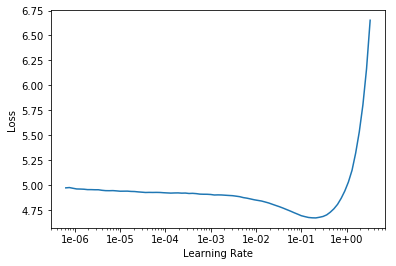

In [143]:
learn.lr_find()
learn.recorder.plot()

Wait what???

In [144]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,3.392817,3.383064,0.312362
2,3.084556,3.279598,0.324559


In [145]:
learn.save('A-LMF2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


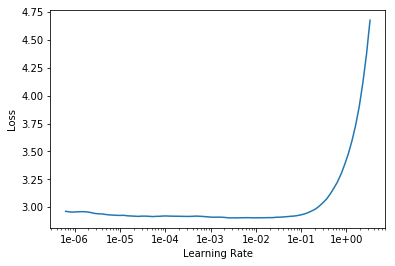

In [146]:
learn.lr_find()
learn.recorder.plot()

In [147]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))
learn.save('A-LMF2U2')


epoch,train_loss,valid_loss,accuracy
1,2.927100,3.227190,0.331853
2,2.661954,3.219970,0.335538


In [172]:
learn.save_encoder('finetuned_enc')

# Essayons le *Language Model*

In [149]:
TEXT = "En accord avec"
N_WORDS = 40
N_SENTENCES = 2

In [150]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

En accord avec l' " xxmaj humanité " et la xxmaj cour des comptes , j' " . xxmaj cette disposition paraît d' " ordre public " . xxmaj dans les faits , cette disposition est toujours d' comme le propose le xxmaj
En accord avec la fonction publique , la lutte contre les discriminations , l' " accueil vers les transports publics " , la lutte contre l' " échec " et la lutte contre les discriminations , l' " égalité sociale et territoriale et


In [151]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=1) for _ in range(N_SENTENCES)))

En accord avec la raison , la desserte de mentale hospitalières est subordonnée à l' " office de surveillance le pousse à l' " ambiguïté mentionne " , ce qui marque une véritable révolution par rapport à la réglementation antérieure . xxbos xxmaj
En accord avec le xxmaj gouvernement et les organisations syndicales , vous avez , avec les juges de proximité , proposer des grandes réformes collectives dans lesquelles seront assumées les agents des différents services . xxmaj les réformes en cours sont intéressantes .


In [153]:
TEXT = "C'est avec grand regret"

In [154]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

C'est avec grand regret de provoquer sa disparition . il aurait fallu qu' " une commission d' " ait été créée , présidé par un préfet . " xxmaj il n' calendrier et est fixé . xxmaj le calendrier demeure : 1 000 agents
C'est avec grand regret des difficultés que vous avez évoquée ! xxmaj je ne me fais donc aucun procès d' " un " bon budget " . xxmaj il ne s' < hommepolitique / > qu' " a priori " pour les collectivités locales


In [155]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=1) for _ in range(N_SENTENCES)))

C'est avec grand regret le gouvernement de < hommepolitique / > . xxmaj il ne seriez jamais très agissait , peut se passer sans m' d' " ait - parachute " . xxmaj s' = coup de impôt lui vaut aussi les options "
C'est avec grand regret que personne ne répondra à ces questions , que ! xxmaj mais son professeur de course lui aussi , dont - est plus proche de l' " xxmaj intelligence états " que les non-cadres ... xxbos xxup l' " appréciation


In [156]:
TEXT = "Je désapprouve"

In [157]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Je désapprouve le texte qui nous est soumis , et qui est de précision . xxmaj les députés attendent que le débat soit ouvert , le plus intéressant , celui que je m' traite de la question . xxmaj nous avons le
Je désapprouve le texte suivant : " xxmaj les effet au niveau de l' " état de santé " , qui est un aspect essentiel de l' " état naturel " de la sécurité sociale , est une nécessité depuis vingt ans


In [158]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=1) for _ in range(N_SENTENCES)))

Je désapprouve les deux mesures en ce sens . xxmaj heureusement , sur le terrain , nous pouvions diversifier nos travaux . xxup c' des dossiers me donne satisfaction fut qu' " il s' " j' les évacuer à la fin de
Je désapprouve la énumérer , ce qui n' reviendrez à noter que cet article ne concerne pas des milliers de kilomètres de zones éligibles à la xxup snpe . xxmaj il se justifie donc également que le souci du xxmaj gouvernement suffira


In [160]:
TEXT = "Ensemble"

In [161]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Ensemble et de notre pays . xxmaj pourquoi ne pas fixer la date à laquelle le roi d' il doit pouvoir " payer " le contingent d' " d' " ign " > ? xxmaj par ailleurs , comme les premiers
Ensemble , et en particulier les autres , de la xxmaj france ... xxmaj pour ce qui est du volet relatif à la formation professionnelle , l' " accord de branche " doit être maintenu , au savoir par la négociation


In [162]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=1) for _ in range(N_SENTENCES)))

Ensemble , heureusement , entre verra le nombre d' " économies " va passer de quelque 300 000 en 2001 à de 42 000 en 2001 . xxmaj en effet , dans ma circonscription , des milliers de personnes ne partent
Ensemble des tarifs régulés sont décidés par les institutions mises en place dans la xxmaj france des états-unis , xxmaj madame la ministre de la santé . xxmaj dans des domaines comme le logement , les banques ou les services publics


In [163]:
TEXT = "Tous ensemble"

In [164]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Tous ensemble , le monde entier a voulu donner à ces jeunes qui avaient suivi une formation initiale au baccalauréat , et non pas des enfants de métiers qui avaient été recrutés après soixante ans de politique de l' " xxmaj europe
Tous ensemble , sur tous les bancs , nous avons eu la possibilité de débattre de la nécessaire constitution d' < < qu' > > . > > xxmaj vous pouvez donc nier que le détail des motifs soient les mêmes .


In [165]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=1) for _ in range(N_SENTENCES)))

Tous ensemble , sans doute leur contribution à la politique de leur ville . xxmaj ces causes sont autant de facteurs d' " augmentation encore plus forte de la consommation de tabac du fait de la perte de pouvoir d' " utilisant
Tous ensemble permettront un meilleur accès aux responsabilités de la suite d' " offre " sur l' " électricité " , l' " énergie d' " alimentation permet de c' le volume de production . xxup l' " affaiblissement de la légitimité


In [167]:
TEXT = "Moi, Président"

In [168]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Moi, Président de la xxmaj république , mais aussi xxmaj monsieur le ministre , qui avait été le rapporteur , nous vous en faisons une fois , sans même parler de la vertu , mais de la compétence des mains de l'
Moi, Président de la xxmaj république , mais surtout ! xxmaj ce n' < < thèmes > > . xxmaj en ce qui concerne la formation professionnelle , il s' < hommepolitique / > à propos de l' " avant - projet


In [169]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=1) for _ in range(N_SENTENCES)))

Moi, Président de la xxmaj république , xxmaj monsieur le ministre , et xxmaj mme < hommepolitique / > , ministre de l' xxup relations xxmaj dieu ou toutes les cultures " . xxup m. < hommepolitique / > , ministre des
Moi, Président de la xxmaj république , auteur de la xxup barre et ministre des transports du début pour le titre xxup iv , je vais passons - pour y répondre . xxup l' " action sociale des assure subjective " de


# Classification

In [173]:
data_clas = TextClasDataBunch.from_df(p/'large_files',
                                      train_df=train_df, valid_df=valid_df,
                                      vocab=data_lm.train_ds.vocab,
                                      text_cols='Text', label_cols='Sent',
                                      tokenizer=tokenizer,
                                      bs=64)

In [175]:
learn = text_classifier_learner(data_clas, drop_mult=0.3)
learn.load_encoder('finetuned_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


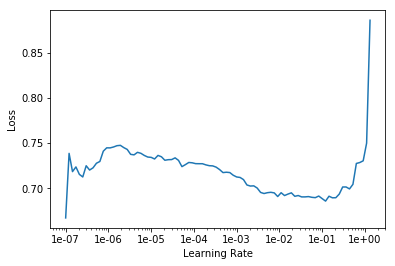

In [176]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [177]:
learn.fit_one_cycle(2, slice(1e-3, 1e-2), moms=(0.8,0.7))
learn.save('A-CLF2-LMF2U2')

epoch,train_loss,valid_loss,accuracy
1,0.612036,0.658164,0.604454
2,0.579854,0.620272,0.644461


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


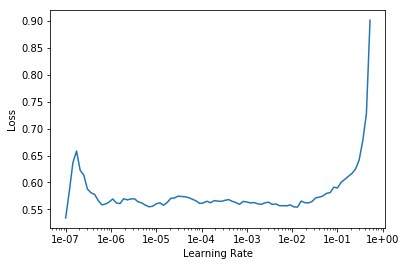

In [179]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


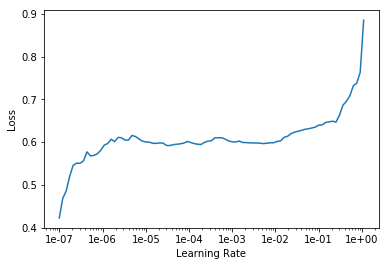

In [180]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [181]:
learn.freeze()
learn.fit_one_cycle(2, slice(1e-3, 1e-2), moms=(0.8,0.7))
learn.save('A-CLF4-LMF2U2')

epoch,train_loss,valid_loss,accuracy
1,0.589846,0.550208,0.719192
2,0.567304,0.590904,0.678241


In [182]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/100, 1e-2/100), moms=(0.8,0.7))
learn.save('A-CLF4U2-LMF2U2')

epoch,train_loss,valid_loss,accuracy
1,0.570960,0.563766,0.710889
2,0.559008,0.568821,0.705982


# Using all data to train language model

In [ ]:
data_lmALL = TextLMDataBunch.from_df(p/'large_files',
                                  train_df=pd.concat([train_df, valid_df, test_df]),
                                  valid_pct=0.1,
                                  text_cols='Text', label_cols='Sent',
                                  tokenizer=tokenizer,
                                  bs=64)

data_lmALL.save('data_lm_all')